# Statistical Methods for High Dimensional Biology (STAT/BIOF/GSAT 540)


# Lecture 5: Two-group Comparisons and Statistical Inference

# Overview
In this lecture, you will learn about ...

### Learning Objectives:
- 1
- 2

### R Dependencies:

- lattice
- latticeExtra
- RColorBrewer

In [21]:
library(knitr)
knitr::opts_knit$set(root.dir=".")

library(lattice)
library(latticeExtra)

jCols <- c(x = "blue", y = "orange")
trellis.par.set(superpose.symbol = list(col = jCols),
                superpose.line = list(col = jCols))
jCex <- 3

# Data description

We will be using the dataset from [SOURCE]

This dataset entails ...

# Loading the data

In [22]:
prDes <- readRDS("data/GSE4051_design.rds")
str(prDes)

prDat<-read.table("data/GSE4051_data.tsv",
                  sep = "\t", header = T, row.names = 1)
str(prDat, list.len = 10)

'data.frame':	39 obs. of  4 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
'data.frame':	29949 obs. of  39 variables:
 $ Sample_20: num  7.24 9.48 10.01 8.36 8.59 ...
 $ Sample_21: num  7.41 10.02 10.04 8.37 8.62 ...
 $ Sample_22: num  7.17 9.85 9.91 8.4 8.52 ...
 $ Sample_23: num  7.07 10.13 9.91 8.49 8.64 ...
 $ Sample_16: num  7.38 7.64 8.42 8.36 8.51 ...
 $ Sample_17: num  7.34 10.03 10.24 8.37 8.89 ...
 $ Sample_6 : num  7.24 9.71 10.17 8.84 8.54 ...
 $ Sample_24: num  7.11 9.75 9.39 8.37 8.36 ...
 $ Sample_25: num  7.19 9.16 10.11 8.2 8.5 ...
 $ Sample_26: num  7.18 9.49 9.41 8.73 8.39 ...
  [list output truncated]


Here we examine the design of the study with a frequency table. We have four samples for each combination of development stage and genotype (except for "E16 and NrlKO", which has 3 samples)

In [23]:
with(prDes, table(devStage, gType))

         gType
devStage  wt NrlKO
  E16      4     3
  P2       4     4
  P6       4     4
  P10      4     4
  4_weeks  4     4

A cursory glance at the experession data reveals:

In [24]:
head(subset(prDat, select = 1:5))

,Sample_20,Sample_21,Sample_22,Sample_23,Sample_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1415670_at,7.236,7.414,7.169,7.070,7.383
1415671_at,9.478,10.020,9.854,10.130,7.637
1415672_at,10.010,10.040,9.913,9.907,8.423
1415673_at,8.362,8.374,8.404,8.487,8.363
1415674_a_at,8.585,8.615,8.520,8.641,8.509
1415675_at,9.591,9.719,9.709,9.700,9.656


# Subsetting the data

Nrl (neural retina leucine zipper gene) is the gene that was knocked out in half the mice, and should obviously be differentially expressed. Nrl’s probeset ID is “1450946_at”. Irs4 (insulin receptor substrate 4) is selected as a boring non-differentially expressed gene. Irs4’s probeset ID is “1422248_at”.

We extract the rows for each of these genes, transpose and then vectorize the data. We then merge this data together with the design metadata. Ensure that the samples match between the data and design before merging.

In [25]:
miniDat <- as.vector(t(prDat[c("1422248_at", "1450946_at"), ]))
miniDat <- data.frame(gene = rep(c("Irs4", "Nrl"), each = nrow(prDes)),
                      gExp = miniDat)
miniDat <- data.frame(prDes, miniDat) # ignore the warning about row names
str(miniDat)

Warning message in data.frame(prDes, miniDat):
"row names were found from a short variable and have been discarded"

'data.frame':	78 obs. of  6 variables:
 $ sidChar : chr  "Sample_20" "Sample_21" "Sample_22" "Sample_23" ...
 $ sidNum  : num  20 21 22 23 16 17 6 24 25 26 ...
 $ devStage: Factor w/ 5 levels "E16","P2","P6",..: 1 1 1 1 1 1 1 2 2 2 ...
 $ gType   : Factor w/ 2 levels "wt","NrlKO": 1 1 1 1 2 2 2 1 1 1 ...
 $ gene    : Factor w/ 2 levels "Irs4","Nrl": 1 1 1 1 1 1 1 1 1 1 ...
 $ gExp    : num  7.87 7.78 7.58 7.4 8.08 ...


# Data visualization for two-group comparisons 

We have a few options to visualize the differences in gene expression between genotypes. In each plot, we generate a panel for each gene.

# Strip plots
One option is to examine a strip plot. The first plot allows the x-axis scale to be freely set for each gene (dependent on the range of gene expression). The second plot forces both panels to have matching x-axis scales, which allows for between gene comparisons as well. The final plot let’s us plot the mean values of gene expression for each gene and genotype.

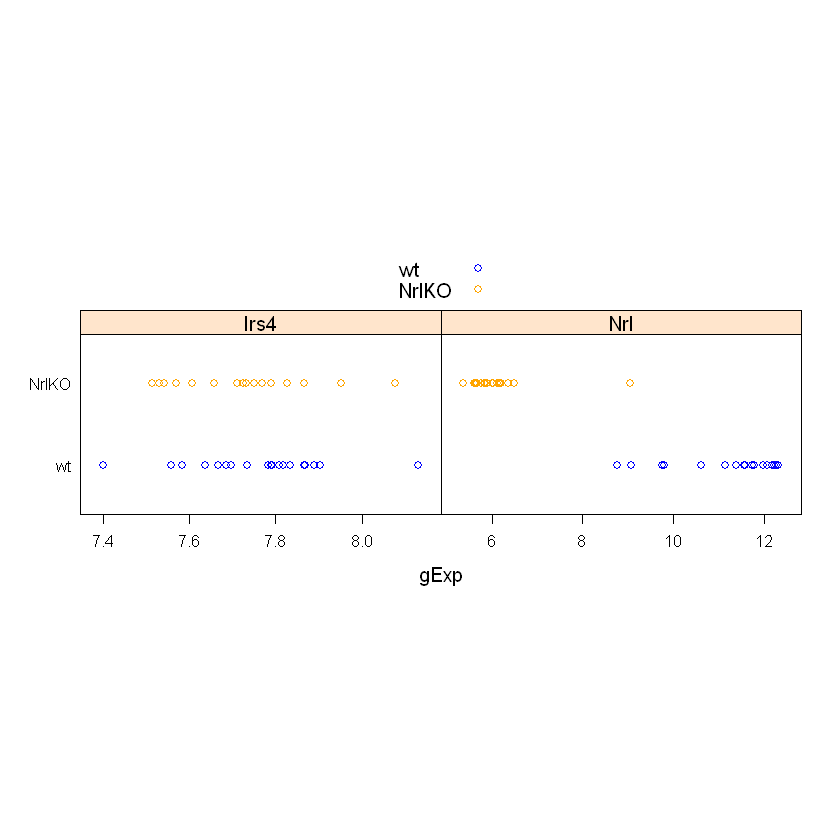

In [29]:
stripplot(gType ~ gExp | gene, miniDat,
          scales = list(x = list(relation = "free")),
          groups = gType, auto.key = TRUE,
          aspect = 0.5, layout = c(2, 1))

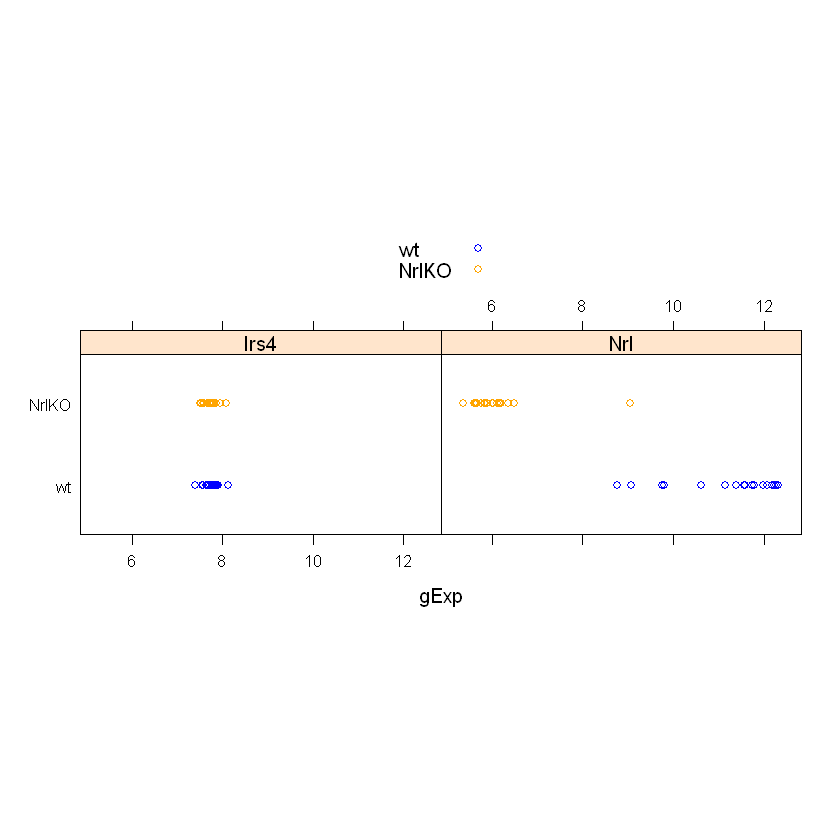

In [30]:

stripplot(gType ~ gExp | gene, miniDat,
          groups = gType, auto.key = TRUE,
          aspect = 0.5, layout = c(2, 1))

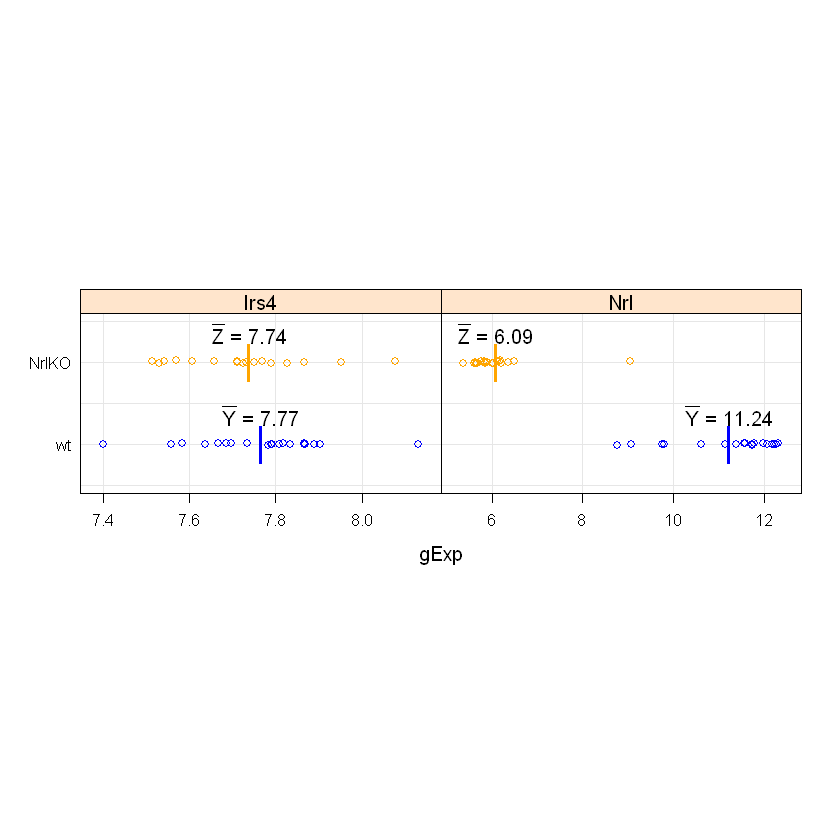

In [31]:
jFudge <- 0.35
stripplot(gType ~ gExp | gene, miniDat,
          grid = TRUE,
          scales = list(x = list(relation = "free")),
          groups = gType, jitter.data = TRUE,
          aspect = 0.5, layout = c(2, 1),
          panel = panel.superpose,
          panel.groups = function(x, y, ..., group.number) {
            yo <- group.number
            panel.stripplot(x, y, ...)
            theAvg <- mean(x)
            panel.points(theAvg, y[1], pch = "|", cex = jCex,
                         col = jCols[group.number])
            jLab <- substitute(paste(bar(Z), " = ", foo),
                        list(Z = c("Y", "Z")[group.number],
                             foo = round(theAvg, 2)))
            panel.text(x = mean(x), y = y[1] + jFudge,
                       jLab)
          })

# Density plots
Another option is to examine a density plot. This plot let's us observe the distributions of gene expression, and how these distributions compare across genotype. The second plot is a "violin" plot, which provides a similar visualization as the density plot.

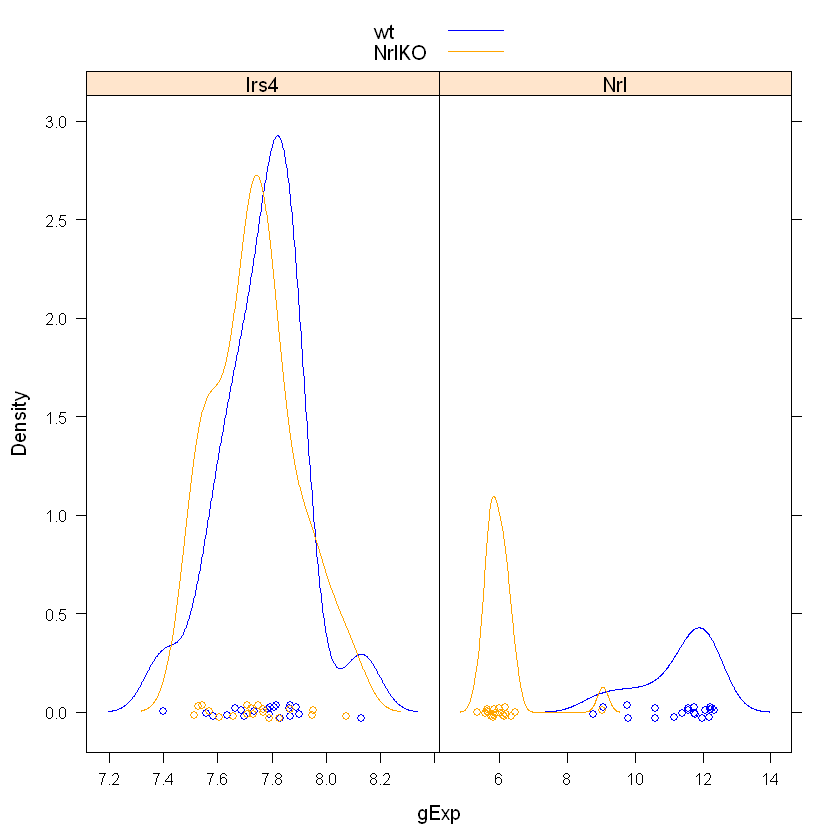

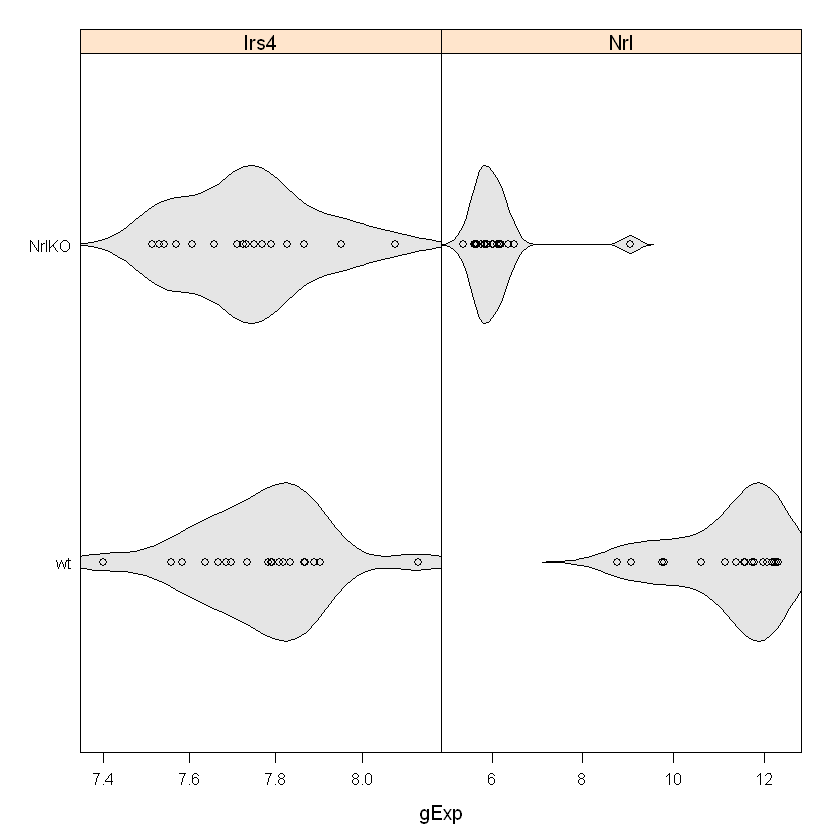

In [27]:
densityplot(~ gExp | gene, miniDat,
            scales = list(x = list(relation = "free")),
            groups = gType, auto.key = TRUE)

bwplot(gType ~ gExp | gene, miniDat,
       scales = list(x = list(relation = "free")),
       panel = function(...) {
         panel.violin(..., col = "grey90")
         panel.stripplot(..., col = "black")
       })

# Boxplots
Boxplots may be another good choice. We can observe the median and IQR of our group distributions, as well as identify any outliers. The second plot combines a boxplot together with a "violin" plot.

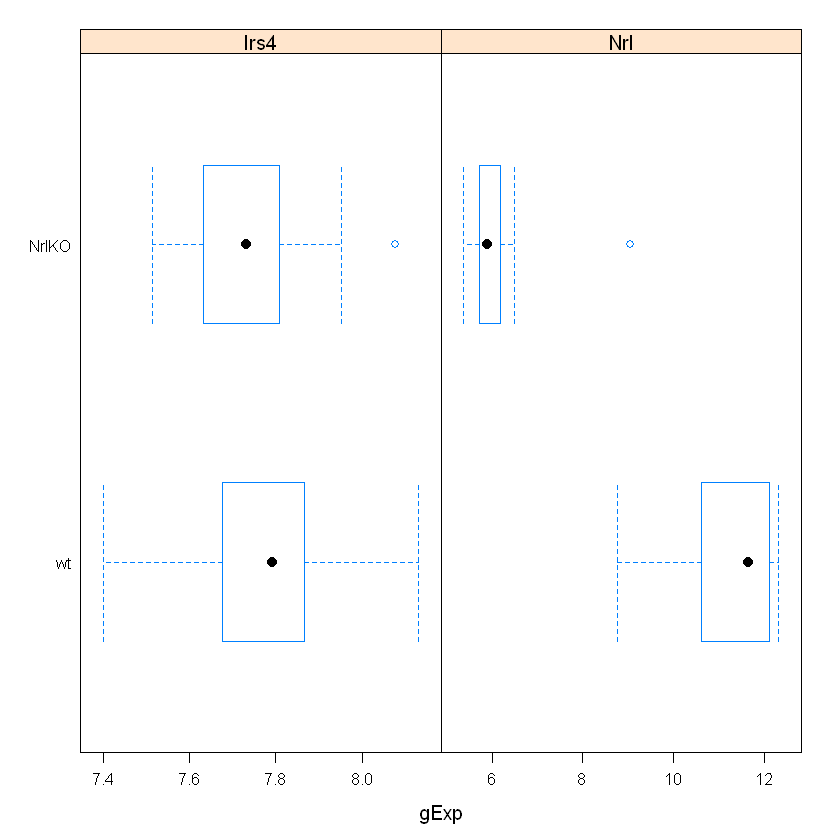

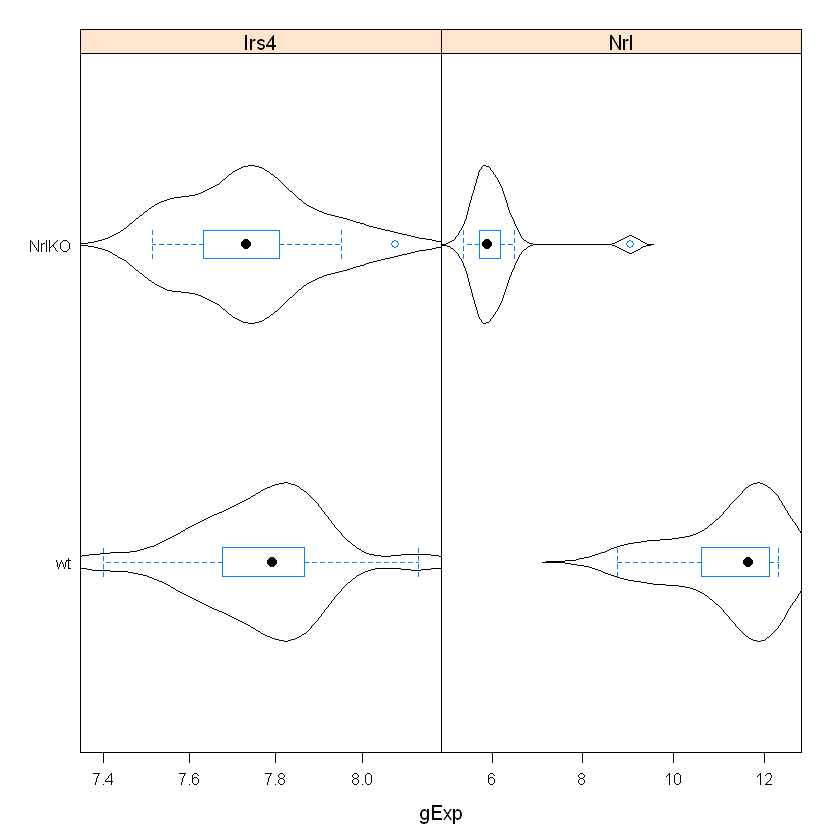

In [28]:
bwplot(gType ~ gExp | gene, miniDat,
       scales = list(x = list(relation = "free")))

bwplot(gType ~ gExp | gene, miniDat,
       scales = list(x = list(relation = "free")),
       panel = function(..., box.ratio) {
         panel.violin(..., col = "transparent", border = "black",
                      varwidth = FALSE, box.ratio = box.ratio)
         panel.bwplot(..., fill = NULL, box.ratio = .1)
       })

# Statistical Inference

# Two-group inference: t-tests

# Two-group inference: Wilcoxon Rank Test